<a href="https://colab.research.google.com/github/sidnet1964/cashback/blob/master/91_%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Телеком — задача проекта

Оператор связи **«Ниединогоразрыва.ком»** хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание данных
Данные состоят из файлов, полученных из разных источников:
> * contract.csv — информация о договоре;
> * personal.csv — персональные данные клиента;
> * internet.csv — информация об интернет-услугах;
> * phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.


## Описание полей данных: 

* BeginDate – дата начала пользования услугами, 
* EndDate – дата окончания пользования услугами, 
* Type – тип договора: ежемесячный, годовой и т.д, 
* PaperlessBilling – факт выставления счёта на электронную почту, 
* PaymentMethod – способ оплаты, 
* MonthlyCharges – ежемесячные траты на услуги, 
* TotalCharges – всего потрачено денег на услуги, 
* Dependents – наличие иждивенцев, 
* Senior Citizen – наличие пенсионного статуса по возрасту, 
* Partner – наличие супруга(и), 
* MultipleLines – наличие возможности ведения параллельных линий во время звонка. 

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
 Молодец, что не забываешь про заголовок и описание, это важно, так и самому удобнее работать, когда они всегда на виду, так и другим будет проще понять, что происходит в твоей тетради :)
</div>

# Подготовка к работе 

In [ ]:
# звгрузка необходимых компонент
!pip install catboost -q
!pip install phik -q

<div class="alert alert-warning">
<h2> Комментарий тимлида 3<a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
    
* Чтобы вся эта информация не выводилась при установке, можно добавить в конце строки `-q`.


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
Замечание принято во внимание. Спасибо за подсказку.
</div>

In [ ]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from time import time
import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

In [ ]:
# определение констант
RANDOM_STATE = 270323
TEST_SIZE = 0.25
# подавление вывода предупреждений
warnings.filterwarnings('ignore')

## Загрузка данных

In [ ]:
try:
    # чтение файлов с данными
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    # загрузка данных, размещенных на Google Диске
    ! gdown 1sxl_lM7EXGiTGc2K-ep1gD5GWGBALxnn -q # contract
    ! gdown 1typTVyYXO2LuDJOc6dqc7x9rpsow1o4A -q  # internet
    ! gdown 1TssIuKTwSwf_pVxPA2drY24IKe6-CivN -q  # personal
    ! gdown 17bvSFhS1RfNJ-eDyQjL8O7rgCwqnAekF -q  # phone
    # чтение файлов с данными
    contract = pd.read_csv('contract.csv')  #  — информация о договоре
    internet = pd.read_csv('internet.csv')  #  — информация об интернет-услугах;
    personal = pd.read_csv('personal.csv')  #  — персональные данные клиента
    phone = pd.read_csv('phone.csv')        #  — информация об услугах телефонии

In [ ]:
# анализ размеров таблиц
print('contract', contract.shape)
print('internet', internet.shape)
print('personal', personal.shape)
print('phone', phone.shape)

contract (7043, 8)
internet (5517, 8)
personal (7043, 5)
phone (6361, 2)


In [ ]:
def duplicated_check(table):
    '''
    Проверка таблицы на наличие дубликатов строк
    Входной параметр:
    - table - дата-фрейм
    Возвращает:
    - в теле функции выводится сообщение
    '''
    duplicated_sum = table.duplicated().sum()
    print('Размер дата-фрейма -', table.shape, end=' ')
    if  duplicated_sum > 0:
        print('Обнаружено дубликатов', duplicated_sum )
    else:
        print('Дубликатов не обнаружено')

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> плюс за функцию, избегаем диблирования кода

### Анализ таблицы `personal` — персональные данные клиента

In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
# произвести переименование столбцов
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
# проверка таблицы на дубликаты
duplicated_check(personal)

Размер дата-фрейма - (7043, 5) Дубликатов не обнаружено


In [ ]:
# анализ баланса классов gender
class_frequency = personal['gender'].value_counts(normalize=True, dropna=False)
print(class_frequency.head())

Male      0.504756
Female    0.495244
Name: gender, dtype: float64


**Вывод**: Распределение клиентов по признаку пола носит естественный характер.

In [ ]:
# анализ баланса классов senior_citizen
class_frequency = personal['senior_citizen'].value_counts(normalize=True, dropna=False)
print(class_frequency.head())

0    0.837853
1    0.162147
Name: senior_citizen, dtype: float64


**Вывод**: Распределение клиентов по пенсионному статусу соответствует демографической ситуации.

In [ ]:
# анализ баланса классов partner
class_frequency = personal['partner'].value_counts(normalize=True, dropna=False)
print(class_frequency.head())

No     0.516967
Yes    0.483033
Name: partner, dtype: float64


In [ ]:
# произвести кодирование признака partner для бустинговых моделей
personal['partner'] = personal.apply(lambda x: 0 if x.partner == 'No' else 1, axis=1)
personal['partner'] = personal['partner'].astype('int')

**Вывод**: Распределение клиентов по семейному статусу соответствует демографической ситуации.

In [ ]:
# анализ баланса классов dependents
class_frequency = personal['dependents'].value_counts(normalize=True, dropna=False)
print(class_frequency.head())

No     0.700412
Yes    0.299588
Name: dependents, dtype: float64


In [ ]:
# произвести кодирование признака dependents для бустинговых моделей
personal['dependents'] = personal.apply(lambda x: 0 if x.dependents == 'No' else 1, axis=1)
personal['dependents'] = personal['partner'].astype('int')

**Вывод**: Распределение клиентов по наличию иждивенцев соответствует демографической ситуации.

In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   int64 
 4   dependents      7043 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 275.2+ KB


**Выводы по таблице `personal`**

* Пропуски и дубликаты отсутствуют.
* Имена переменных переведены к стилю snake_case
* Для полей 'partner', 'dependents' проведено ординарное кодирование и установлен тип `int`

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> хорошо, плюс за промежуточные выводы

### Анализ таблицы `contract` — информация о договоре


In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
# произвести переименование столбцов
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type',
                    'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']
# проверка таблицы на дубликаты
duplicated_check(contract)

Размер дата-фрейма - (7043, 8) Дубликатов не обнаружено


**Создание целевого признака**

In [ ]:
# создать целевой признак на основе end_date
contract['exit'] = contract.apply(lambda x: 0 if x.end_date == 'No' else 1, axis=1)

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> таргет выделен верно

In [ ]:
# анализ баланса классов
class_frequency = contract['exit'].value_counts(normalize=True, dropna=False)
print(class_frequency.head())

0    0.73463
1    0.26537
Name: exit, dtype: float64


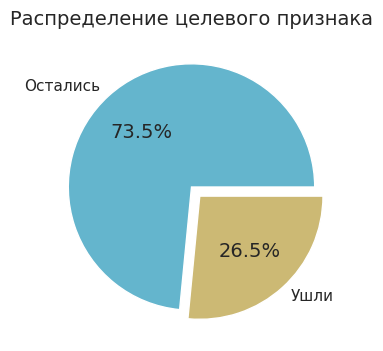

In [ ]:
plt.subplots(figsize=(4, 4))
plt.rcParams['font.size'] = 14
plt.pie(class_frequency, explode=(0, 0.1), labels=['Остались', 'Ушли'], 
        autopct='%1.1f%%', colors=['c','y'])
plt.title("Распределение целевого признака", size = 14)
plt.show()

**Вывод**: Отток клиентов составляет 26.5%. 

Необходимо проанализировать факторы, влияющие на решение отказаться от услуг и стимулировать лояльность клиентов.

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> отлично, что сразу анализируешь дисбланс классов

**Обработка временнЫх признаков**

In [ ]:
# приведение колонки к типу'date'
contract['begin_date'] = pd.to_datetime(contract['begin_date'])
# запомнить границы интервала begin_date
begin_date_min = contract['begin_date'].describe(datetime_is_numeric=True)[2]
begin_date_max = contract['begin_date'].describe(datetime_is_numeric=True)[6]
begin_date_min, begin_date_max

(Timestamp('2013-10-01 00:00:00'), Timestamp('2020-02-01 00:00:00'))

In [ ]:
# анализ распределения begin_date для тех клиентов, кто реально расторг контракт
class_frequency = contract.loc[contract['exit'] == 1, 'begin_date'].value_counts(normalize=True, dropna=False)
print(class_frequency.head())

2019-09-01    0.089888
2019-10-01    0.077047
2019-11-01    0.070091
2019-12-01    0.056180
2019-08-01    0.040663
Name: begin_date, dtype: float64


In [ ]:
# анализ распределения end_date для тех клиентов, кто реально расторг контракт
class_frequency = contract.loc[contract['exit'] == 1, 'end_date'].value_counts(normalize=True, dropna=False)
print(class_frequency.head())

2019-11-01 00:00:00    0.259497
2019-12-01 00:00:00    0.249331
2020-01-01 00:00:00    0.246121
2019-10-01 00:00:00    0.245051
Name: end_date, dtype: float64


In [ ]:
# заменить 'пропущенные' значения в поле end_date максимальным значением
contract['end_date'] = contract['end_date'].replace('No', begin_date_max)
# приведение колонки к типу'to_datetime'
contract['end_date'] = pd.to_datetime(contract['end_date'])

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>  отлично

In [ ]:
def count_months(row):
    '''
    Функция вычисляет количество месяцев между двумя датами
    Входной параметр:
    - row - строка с данными одного клиента/контракта
    Возращает:
    - количество месяцев в интервале
    '''
    year = row['end_date'].year - row['begin_date'].year
    month = row['end_date'].month - row['begin_date'].month
    data = (year * 12 + month + 1) * 30
    return data

In [ ]:
# расчет данных по всем клиентам
contract['count_months'] = contract.apply(count_months, axis = 1)

**Обработка категориальных признаков**

In [ ]:
# найти проблему в поле total_charges, из-за которой тип определен как object
contract['total_charges'].value_counts().head()

         11
20.2     11
19.75     9
20.05     8
19.9      8
Name: total_charges, dtype: int64

In [ ]:
# вывести пробелы в поле total_charges
contract.loc[contract.loc[:, 'total_charges'] == ' '].head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exit,count_months
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,30
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,30
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,30
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,30
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,30


**Замечание**

В поле total_charges стоят пробелы у тех клиентов, кто подключился 2020-02-01 (последный меcяц доступного интервала).

Пробел нужно заменить на число 0 и привести тип признака к `float`

In [ ]:
# в поле total_charges стоят пробелы у тех, кто подключился 2020-02-01
# заменить пропущенные значения в поле total_charges
contract['total_charges'] = contract['total_charges'].replace(' ', 0)
# преобразовать тип колонки total_charges
contract['total_charges'] = contract['total_charges'].astype('float')

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> хорошо, согласна

In [ ]:
# анализ баланса классов dependents
class_frequency = contract['type'].value_counts(normalize=True, dropna=False)
print(class_frequency.head())

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: type, dtype: float64


**Вывод**: Больше половины клиентов предпочитают ежемесячную оплату услуг. Остальные выбрали годовой или двухгодичный контракт.

In [ ]:
# анализ баланса классов paperless_billing
class_frequency = contract['paperless_billing'].value_counts(normalize=True, dropna=False)
print(class_frequency.head())

Yes    0.592219
No     0.407781
Name: paperless_billing, dtype: float64


In [ ]:
# произвести кодирование признака paperless_billing для бустинговых моделей
contract['paperless_billing'] = contract.apply(lambda x: 0 if x.paperless_billing == 'No' else 1, axis=1)
contract['paperless_billing'] = contract['paperless_billing'].astype('int')

In [ ]:
# анализ баланса классов payment_method
class_frequency = contract['payment_method'].value_counts(normalize=True, dropna=False)
print(class_frequency.head())

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: payment_method, dtype: float64


**Вывод**: Треть клиентов предпочитают электронный способ оплаты. Остальные равномерно распределились среди других вариантов.

In [ ]:
# распределение числовых переменных
contract.describe()

,paperless_billing,monthly_charges,total_charges,exit,count_months
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.592219,64.761692,2279.734304,0.265370,1001.134460
std,0.491457,30.090047,2266.794470,0.441561,736.784431
min,0.000000,18.250000,0.000000,0.000000,30.000000
25%,0.000000,35.500000,398.550000,0.000000,300.000000
50%,1.000000,70.350000,1394.550000,0.000000,900.000000
75%,1.000000,89.850000,3786.600000,1.000000,1680.000000
max,1.000000,118.750000,8684.800000,1.000000,2190.000000


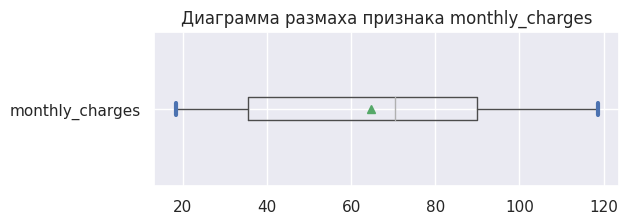

In [ ]:
# вывод диаграмм размаха
plt.figure(figsize=(6, 2))
plt.title('Диаграмма размаха признака monthly_charges') # заголовок
contract.boxplot(['monthly_charges'], 
                  vert=False,
                  showcaps=True,  # Покажите черточки на концах усов.
                  showbox=True,   # Покажите центральную рамку.
                  showfliers=True, # Покажите выбросы за заглавными буквами. 
                  showmeans=True,  # Покажите средние арифметические.
                  capprops={"color": "C0", "linewidth": 3},  # Фасон кепок.
                  );

**Вывод**: выбросы отсутствуют, распределение соответствует действующим тарифам. 

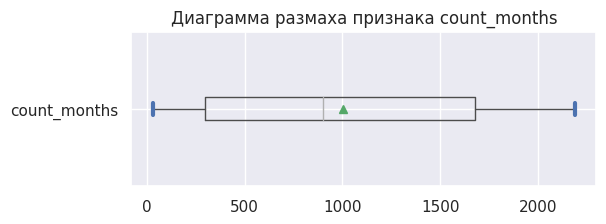

In [ ]:
# вывод диаграмм размаха
plt.figure(figsize=(6, 2))
plt.title('Диаграмма размаха признака count_months') # заголовок
contract.boxplot(['count_months'], 
                  vert=False,
                  showcaps=True,  # Покажите черточки на концах усов.
                  showbox=True,   # Покажите центральную рамку.
                  showfliers=True, # Покажите выбросы за заглавными буквами. 
                  showmeans=True,  # Покажите средние арифметические.
                  capprops={"color": "C0", "linewidth": 3},  # Фасон кепок.
                  );

**Вывод**: выбросы отсутствуют, распределение соответствует анализируемому интервалу. 

In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   exit               7043 non-null   int64         
 9   count_months       7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 550.4+ KB


**Выводы по таблице `contract`**

* Пропуски и дубликаты отсутствуют.
* Имена переменных переведены к стилю snake_case
* В полях end_date и total_charges обнаружены и устранены смешения типов
* Для поля begin_date и end_date проведено преобразование к типу `datetime64`
* Добавлен новый признак `count_months` - продолжительность контракта в месяцах
* Установлен и заполнен целевой признак `exit`

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> супер! отличный пердварительный анализ

### Анализ таблицы `internet` — информация об интернет-услугах

In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
# произвести переименование столбцов
internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
# проверка таблицы на дубликаты
duplicated_check(internet)

Размер дата-фрейма - (5517, 8) Дубликатов не обнаружено


In [ ]:
# добавить признак - включен пакет "Интернет"
internet['internet_inc'] = 1

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> хорошо

In [ ]:
# анализ баланса классов internet_service
class_frequency = internet['internet_service'].value_counts(normalize=True, dropna=False)
print(class_frequency.head())

Fiber optic    0.561175
DSL            0.438825
Name: internet_service, dtype: float64


**Вывод**: Больше половины клиентов выбрали способ подключения к сети Интернет с помощью оптического кабеля. 44% используют для этого телефонную линию.

In [ ]:
# остальные признаки обработаем списком, варианты кодировки
# 1)  0=NaN, 0=No, 1=Yes - пользуется или нет - текущий вариант
# список услуг в пакете 'internet_inc'
internet_list = [
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies']

for item in internet_list:
    # проверить бинарный характер признака
    internet[item] = internet.apply(lambda x: 1 if x[item] == 'Yes' else 0, axis=1)
    internet[item] = internet[item].astype('int')

**Замечание** : Набор услуг, которые выбирает клиент целесообразно проанализировать после объединения таблиц, так как это связано со стоимостью пакета. 

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> согласна

In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   int64 
 3   online_backup      5517 non-null   int64 
 4   device_protection  5517 non-null   int64 
 5   tech_support       5517 non-null   int64 
 6   streaming_tv       5517 non-null   int64 
 7   streaming_movies   5517 non-null   int64 
 8   internet_inc       5517 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 388.0+ KB


**Выводы по таблице `internet`**

* Пропуски и дубликаты отсутствуют.
* Имена переменных переведены к стилю snake_case
* Для полей, определяющих набор опций, проведено преобразование к типу `int`
* Добавлен новый признак `internet_inc` - подписка на услугу

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> идем дальше

### Анализ таблицы `phone` — информация об услугах телефонии

In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
# произвести переименование столбцов
phone.columns = ['customer_id', 'multiple_lines']
# проверка таблицы на дубликаты
duplicated_check(phone)

Размер дата-фрейма - (6361, 2) Дубликатов не обнаружено


In [ ]:
# включен пакет "Стационарная телефонная связь"
phone['phone_inc'] = 1

In [ ]:
# анализ баланса классов partner
class_frequency = phone['multiple_lines'].value_counts(normalize=True, dropna=False)
print(class_frequency.head())

No     0.532935
Yes    0.467065
Name: multiple_lines, dtype: float64


In [ ]:
# варианты кодировки
# 1)  0=NaN, 0=No, 1=Yes - пользуется или нет - текущий вариант
# список услуг в пакете 'phone_inc'
# произвести кодирование признака multiple_lines для бустинговых моделей
phone['multiple_lines'] = phone.apply(lambda x: 0 if x.multiple_lines == 'No' else 1, axis=1)
phone['multiple_lines'] = phone['multiple_lines'].astype('int')

**Замечание** : Набор услуг, которые выбирает клиент целесообразно проанализировать после объединения таблиц, так как это связано со стоимостью пакета. 

In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   int64 
 2   phone_inc       6361 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 149.2+ KB


**Выводы по таблице `phone`**

* Пропуски и дубликаты отсутствуют.
* Имена переменных переведены к стилю snake_case
* Для поля multiple_lines проведено преобразование к типу `int`
* Добавлен новый признак `phone_inc` - подписка на услугу

## Предварительные выводы

* Пропуски и дубликаты во всех таблицах отсутствуют.
* Имена всех признаков переведены к стилю snake_case
* Все признаки, содержащие "Yes"/"No" преобразованы к типу int
* Добавлены новые признаки для дальнейшего объединения таблиц



---



---



---



# Объединение всех таблиц в одну - `df`

## Выявление и заполнение пропусков

In [ ]:
# объединить все таблицы в одну, за основу взять personal
df = personal.merge(contract, on=['customer_id'], how='outer').\
              merge(internet, on=['customer_id'], how='outer').\
              merge(phone, on=['customer_id'], how='outer')
# установить индекс таблицы равным столбцу datetime
df = df.set_index('customer_id')

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> датасет собран верно

In [ ]:
# удалить пропуски в признаках, отвечающих за категории услуг
df['internet_inc'] = df['internet_inc'].fillna(0)
df['internet_inc'] = df['internet_inc'].astype('int')

df['phone_inc'] = df['phone_inc'].fillna(0)
df['phone_inc'] = df['phone_inc'].astype('int')

# значение для NaN в поле internet_service при отсутствии услуги "Интернет"
df['internet_service'] = df['internet_service'].fillna('None')
df['multiple_lines'] = df['multiple_lines'].fillna(0).astype('int')

# заполним пропуски числом 0, что фактически означает отсуствие услуги
for item in internet_list:
    df[item] = df[item].fillna(0).astype('int')

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> хорошо

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   gender             7043 non-null   object        
 1   senior_citizen     7043 non-null   int64         
 2   partner            7043 non-null   int64         
 3   dependents         7043 non-null   int64         
 4   begin_date         7043 non-null   datetime64[ns]
 5   end_date           7043 non-null   datetime64[ns]
 6   type               7043 non-null   object        
 7   paperless_billing  7043 non-null   int64         
 8   payment_method     7043 non-null   object        
 9   monthly_charges    7043 non-null   float64       
 10  total_charges      7043 non-null   float64       
 11  exit               7043 non-null   int64         
 12  count_months       7043 non-null   int64         
 13  internet_service   7043 non-null   object        
 14

In [ ]:
df.head()

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet_inc,multiple_lines,phone_inc
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,1,1,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,...,DSL,0,1,0,0,0,0,1,0,0
5575-GNVDE,Male,0,0,0,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,...,DSL,1,0,1,0,0,0,1,0,1
3668-QPYBK,Male,0,0,0,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,...,DSL,1,1,0,0,0,0,1,0,1
7795-CFOCW,Male,0,0,0,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,...,DSL,1,0,1,1,0,0,1,0,0
9237-HQITU,Female,0,0,0,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,...,Fiber optic,0,0,0,0,0,0,1,0,1


**Выводы по объединенной таблице `df`**

* Дубликаты в таблице отсутствуют
* Пропуски выявлены и заполнены
* Имена переменных переведены к стилю snake_case
* Для признаков `begin_date` и `end_date` проведено преобразование к типу `datetime64`
* Все признаки, содержащие "Yes"/"No" преобразованы к типу `int`
* Добавлены новые признаки:
* - `internet_inc` - наличие услуги "Интернет"
* - `phone_inc` - наличие услуги "Телефон"
* - `count_months` - продолжительность контракта в месяцах
* Установлен и заполнен целевой признак `exit`

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> хорошо, идем дальше

### Выявление и устранение проблем в данных

In [ ]:
# создать дополнительный признак - год заключения контракта
df['begin_year'] = pd.DatetimeIndex(df['begin_date']).year
# группировка информации о начале контракта в разрезе календарного года
df_year_counts = df.groupby(['begin_year'])['exit'].agg(['sum', 'count', 'mean'])
df_year_counts

,sum,count,mean
begin_year,,,
2013,8,8,1.000000
2014,98,1344,0.072917
2015,123,852,0.144366
2016,145,763,0.190039
2017,199,845,0.235503
2018,315,1030,0.305825
2019,981,1957,0.501277
2020,0,244,0.000000


**Замечание:** При анализе распределения данных по годам обнаружилось:
* доля контрактов, заключенных в 2013-м году несущественна и записи можно удалить
* информация о расторжении контрактов в январе-феврале 2020 года еще не внесена в базу данных. Этот период также можно удалить, чтобы избежать искажения в расчетах.

In [ ]:
# удаления начального и конечного отрезков 
df = df.loc[(df.begin_date > '2013-12-01 00:00:00') & (df.begin_date < '2020-01-01 00:00:00')]
df.shape

(6791, 24)

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> аргументировано, согласна

## Анализ зависимости целевого признака от входных данных

### Группировка информации по годам

In [ ]:
# группировка информации о начале контракта в разрезе календарного года
df_year_counts = df.groupby(['begin_year'])['exit'].agg(['sum', 'count', 'mean']) # , 'mean'
df_year_counts

,sum,count,mean
begin_year,,,
2014,98,1344,0.072917
2015,123,852,0.144366
2016,145,763,0.190039
2017,199,845,0.235503
2018,315,1030,0.305825
2019,981,1957,0.501277


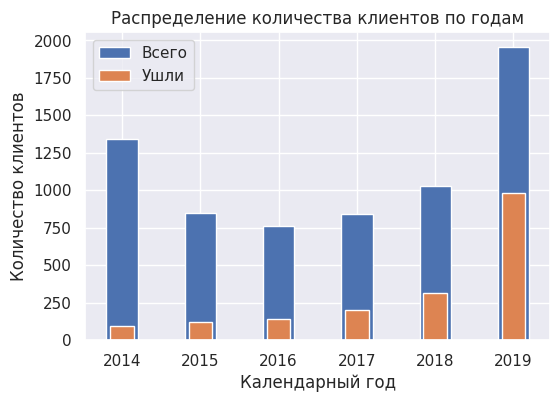

In [ ]:
# Распределение количества клиентов по году (столбчатая диаграмма)
plt.figure(figsize = (6, 4))
plt.bar(df_year_counts.index.astype('str'), df_year_counts['count'], width=0.4) # , width=0.4
plt.bar(df_year_counts.index.astype('str'), df_year_counts['sum'], width=0.3) # , width=0.6
plt.legend(['Всего', 'Ушли'])
#plt.xlim(18, 70)
plt.title('Распределение количества клиентов по годам')
plt.xlabel('Календарный год')
plt.ylabel('Количество клиентов')
# plt.xticks(rotation=45)
plt.show()

**Вывод**: наблюдается высокая лояльность среди клиентов с большим стажем. Половина клиентов, подключившихся в 2019-м году, разорвали контракт с оператором.

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> отлично, плюс за визуализацию

<Figure size 600x400 with 0 Axes>

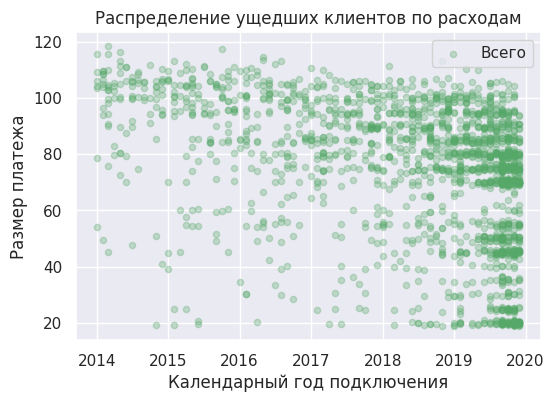

In [ ]:
# Распределение клиентов по расходам (диаграмма рассеяния)
plt.figure(figsize = (6, 4))
df.loc[df['exit'] == 1].plot(x='begin_date', y='monthly_charges', kind='scatter', grid=True, alpha=0.3, color="g", figsize=(6, 4)) # , width=0.4
plt.legend(['Всего', 'Ушли'])
# plt.xlim(18, 80)
plt.title('Распределение ущедших клиентов по расходам')
plt.xlabel('Календарный год подключения')
plt.ylabel('Размер платежа')
# plt.xticks(rotation=45)
plt.show();

**Вывод**: расходы большинства отключившихся клиентов выше среднего уровня.

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> хорошо

### Распределение целевого признака относительно `monthly_charges_cut`

In [ ]:
# группировка клиентов по затратам
df['monthly_charges_cut'] = pd.qcut(df['monthly_charges'],5)
# df['monthly_charges_cut'] = df['monthly_charges_cut'].astype('str')
df_monthly_charges = df.groupby(['monthly_charges_cut'])['exit'].agg(['sum', 'count', 'mean'])
df_monthly_charges

,sum,count,mean
monthly_charges_cut,,,
"(18.249, 25.25]",140,1364,0.102639
"(25.25, 60.05]",353,1356,0.260324
"(60.05, 79.6]",440,1356,0.324484
"(79.6, 94.55]",491,1358,0.361561
"(94.55, 118.75]",437,1357,0.322034


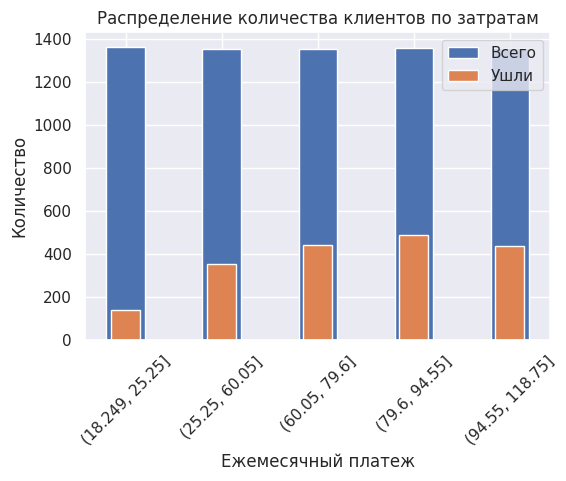

In [ ]:
# Распределение количества клиентов по затратам (столбчатая диаграмма)
plt.figure(figsize = (6, 4))
plt.bar(df_monthly_charges.index.astype('str'), df_monthly_charges['count'], width=0.4) # , width=0.4
plt.bar(df_monthly_charges.index.astype('str'), df_monthly_charges['sum'], width=0.3) # , width=0.6
plt.legend(['Всего', 'Ушли'])
#plt.xlim(18, 70)
plt.title('Распределение количества клиентов по затратам')
plt.xlabel('Ежемесячный платеж')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

**Примечание**: создан новый синтетический признак `monthly_charges_cut` для разделения клиентов по расходам.

### Распределение целевого признака относительно `count_months_cut`

In [ ]:
# группировка клиентов по затратам
df['count_months_cut'] = pd.qcut(df['count_months'],5)
# df['count_months_cut'] = df['count_months_cut'].astype('str')
df_count_months = df.groupby(['count_months_cut'])['exit'].agg(['sum', 'count', 'mean'])
df_count_months

,sum,count,mean
count_months_cut,,,
"(59.999, 240.0]",835,1368,0.610380
"(240.0, 690.0]",460,1419,0.324172
"(690.0, 1260.0]",285,1325,0.215094
"(1260.0, 1860.0]",204,1356,0.150442
"(1860.0, 2190.0]",77,1323,0.058201


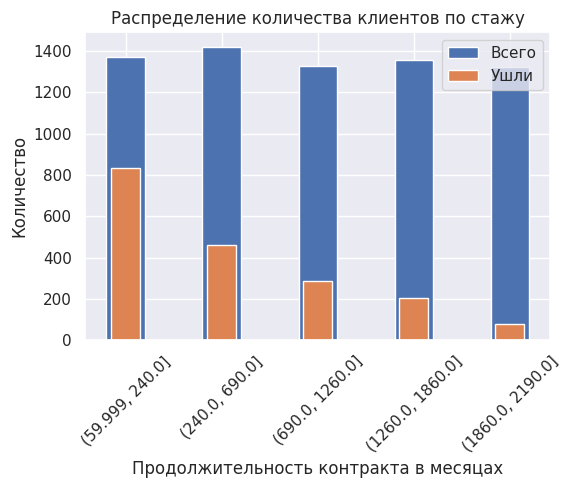

In [ ]:
# Распределение количества клиентов по стажу (столбчатая диаграмма)
plt.figure(figsize = (6, 4))
plt.bar(df_count_months.index.astype('str'), df_count_months['count'], width=0.4) # , width=0.4
plt.bar(df_count_months.index.astype('str'), df_count_months['sum'], width=0.3) # , width=0.6
plt.legend(['Всего', 'Ушли'])
#plt.xlim(18, 70)
plt.title('Распределение количества клиентов по стажу')
plt.xlabel('Продолжительность контракта в месяцах')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

**Примечание**: создан новый синтетический признак `count_months_cut` для разделения клиентов по стажу.

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> хорошо, здесь можно также проанализировать и другие признаки - будет более полная картина

## Анализ корреляции между признаками с помощью пакета Phik

In [ ]:
# удалить временнЫе признаки и их производные
drop_list = ['begin_date', 'end_date', 'begin_year']
df = df.drop(drop_list, axis=1)

In [ ]:
# определить список числовых признаков 'count_months' и признаки типа 'float64'
interval_list = df.select_dtypes('float64').columns.tolist() + ['count_months']
interval_cols = df[interval_list]
interval_cols.columns

Index(['monthly_charges', 'total_charges', 'count_months'], dtype='object')

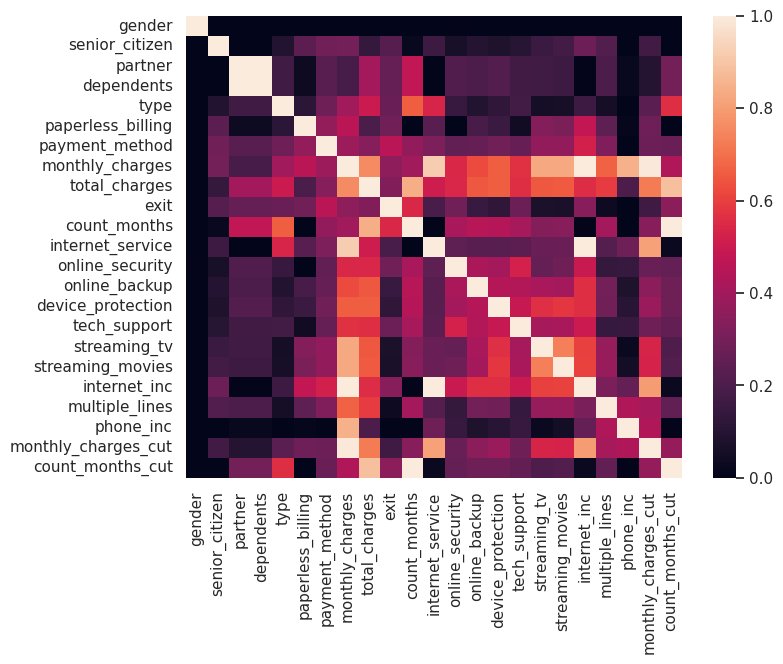

In [ ]:
# сформировать матрицу корреляции с учетом числовых признаков
#define figure size
sns.set(rc={"figure.figsize":(8 , 6 )})
phik_overview = df.phik_matrix(interval_cols=interval_cols)
# отобразить корреляцию на графике
sns.heatmap(phik_overview, vmax=1, vmin=0);

In [ ]:
# отобразить корреляцию в таблице
phik_overview.head()

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,exit,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet_inc,multiple_lines,phone_inc,monthly_charges_cut,count_months_cut
gender,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002269
senior_citizen,0.0,1.000000,0.000000,0.000000,0.093023,0.241357,0.287489,0.295346,0.139043,0.226299,...,0.094385,0.081366,0.101731,0.155227,0.178938,0.274579,0.213041,0.000000,0.173357,0.000000
partner,0.0,0.000000,1.000000,1.000000,0.170928,0.033289,0.227089,0.188956,0.404718,0.262415,...,0.202043,0.217731,0.175626,0.170719,0.161218,0.004241,0.200795,0.022638,0.094212,0.295540
dependents,0.0,0.000000,1.000000,1.000000,0.170928,0.033289,0.227089,0.188956,0.404718,0.262415,...,0.202043,0.217731,0.175626,0.170719,0.161218,0.004241,0.200795,0.022638,0.094212,0.295540
type,0.0,0.093023,0.170928,0.170928,1.000000,0.115955,0.278897,0.401968,0.496543,0.269936,...,0.091151,0.128707,0.175792,0.055677,0.059627,0.162554,0.056237,0.000000,0.236613,0.559530


In [ ]:
# преобразовать матрицу корреляции и отобрать зависимости выше 0.95
phik_overview.reset_index().melt(id_vars='index')\
    .rename(columns={'index': 'variable1', 
                     'variable': 'variable2', 
                     'value': 'correlation'})\
    .sort_values('correlation', ascending=False)\
    .query('correlation.between(.95, 1, inclusive=False)', 
           engine='python') # workaround of this bug

,variable1,variable2,correlation
179,internet_inc,monthly_charges,0.998911
421,monthly_charges,internet_inc,0.998911
252,count_months_cut,count_months,0.998158
516,count_months,count_months_cut,0.998158
182,monthly_charges_cut,monthly_charges,0.995215
490,monthly_charges,monthly_charges_cut,0.995215


In [ ]:
# корреляция с целевым признаком, критических зависимостей нет
phik_overview['exit'].sort_values(ascending=False)

exit                   1.000000
count_months           0.543974
payment_method         0.459691
monthly_charges        0.355545
count_months_cut       0.348945
internet_inc           0.341894
total_charges          0.327239
paperless_billing      0.290088
online_security        0.285972
tech_support           0.276894
type                   0.269936
partner                0.262415
dependents             0.262415
senior_citizen         0.226299
internet_service       0.191541
monthly_charges_cut    0.167299
online_backup          0.150377
device_protection      0.128415
streaming_tv           0.072473
streaming_movies       0.069537
multiple_lines         0.031617
phone_inc              0.000000
gender                 0.000000
Name: exit, dtype: float64

**Вывод**: утечек целевого признака не обнаружено

<div class="alert alert-success">
<h2> Комментарий тимлида<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> хорошо
        
На будущее, полезные ссылки - проверка важности признаков по модели это только один из способов (корреляция в том числе). Используют также аналитические методы проверки гипотез. 

Есть несколько инструментов для отбора признаков, подробнее можно посмотреть в данной статье (Отбор признаков в задачах машинного обучения): https://habr.com/ru/post/550978/

В библиотеке sklearn есть методы mutual_info_regression и mutual_info_classif соответственно для регрессии и классификации.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif

## Построение портрета уходящего клиента

In [ ]:
# Анализ клиента в зависимости от набора параметров
df_exit = df.groupby(['count_months_cut', 'type', 'internet_service', 'internet_inc', 'phone_inc'], dropna=False)['exit'].agg(['count', 'sum', 'mean']).reset_index()
df_exit.loc[df_exit['mean'] > 0.5]

,count_months_cut,type,internet_service,internet_inc,phone_inc,count,sum,mean
2,"(59.999, 240.0]",Month-to-month,DSL,1,0,135,86,0.637037
3,"(59.999, 240.0]",Month-to-month,DSL,1,1,307,166,0.540717
7,"(59.999, 240.0]",Month-to-month,Fiber optic,1,1,646,499,0.772446
43,"(240.0, 690.0]",Month-to-month,Fiber optic,1,1,596,330,0.553691


**Вывод**: отключившихся клиентов мы можем увидеть среди:
* использующих ежемесячую оплату;
* подключившихся менее 8 месяцев назад;
* использующих услугу "Интернет" любого типа подключения.

<div class="alert alert-success">
<h2> Комментарий тимлида<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Отлично!

# Подготовка данных для обучения

## Отбор признаков

In [ ]:
# https://github.com/catboost/catboost/issues/606
# если оставить переменные с типом category, возникает ошибка
# Error : Cannot convert Categorical to numpy.ndarray
df['monthly_charges_cut'] = df['monthly_charges_cut'].astype('str')
df['count_months_cut'] = df['count_months_cut'].astype('str')
# удалить признаки с невысокой важностью
# drop_list = ['gender'] + ['device_protection'] + ['paperless_billing']
drop_list = ['gender']
df = df.drop(drop_list, axis=1)
object_columns = df.select_dtypes('object').columns.tolist()
# object_columns

<div class="alert alert-success">
<h2> Комментарий тимлида<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> хорошо, сделан отбор признаков

## Разделение выборки на обучающую и тестовую

In [ ]:
# разделение по признакам
features = df.drop('exit', axis=1)
target = df['exit']

In [ ]:
ord_enc = OrdinalEncoder(handle_unknown='error')
# OneHotEncoder(handle_unknown='ignore', sparse=False)
features[object_columns] = ord_enc.fit_transform(features[object_columns])
features[object_columns] = features[object_columns].astype('int')

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6791 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   senior_citizen       6791 non-null   int64  
 1   partner              6791 non-null   int64  
 2   dependents           6791 non-null   int64  
 3   type                 6791 non-null   int64  
 4   paperless_billing    6791 non-null   int64  
 5   payment_method       6791 non-null   int64  
 6   monthly_charges      6791 non-null   float64
 7   total_charges        6791 non-null   float64
 8   count_months         6791 non-null   int64  
 9   internet_service     6791 non-null   int64  
 10  online_security      6791 non-null   int64  
 11  online_backup        6791 non-null   int64  
 12  device_protection    6791 non-null   int64  
 13  tech_support         6791 non-null   int64  
 14  streaming_tv         6791 non-null   int64  
 15  streaming_movies     6791 no

In [ ]:
# from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
# X, y = load_digits(return_X_y=True)
features.shape

features_new = SelectKBest(chi2, k=18).fit_transform(features, target)
features.shape, features_new.shape


((6791, 21), (6791, 18))

In [ ]:
# get_feature_names_out([input_features])
features_new[0]

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
       3.0000e+00, 5.6950e+01, 1.8895e+03, 1.0500e+03, 1.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.0000e+00, 1.0000e+00, 4.0000e+00])

In [ ]:
# разделение по выборкам
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=target, shuffle=True)

<div class="alert alert-success">
<h2> Комментарий тимлида<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> верно

In [ ]:
print('Размер исходной выбороки, доля "1"')
print('features      -', features.shape)
print('target        -', target.shape, '{0:.2%}'.format(target.mean()))
print('Размеры выборок после разделения, доля "1"')
print('features_train-', features_train.shape)
print('target_train  -', target_train.shape, '{0:.2%}'.format(target_train.mean()))
print('features_test -', features_test.shape)
print('target_test   -', target_test.shape, '{0:.2%}'.format(target_test.mean()))

Размер исходной выбороки, доля "1"
features      - (6791, 21)
target        - (6791,) 27.40%
Размеры выборок после разделения, доля "1"
features_train- (5093, 21)
target_train  - (5093,) 27.41%
features_test - (1698, 21)
target_test   - (1698,) 27.39%


In [ ]:
# список категориальных признаков
cat_columns = features_train.select_dtypes('object').columns.tolist() + \
              features_train.select_dtypes('int64').columns.tolist()
cat_columns.remove('count_months')
# проверка списка числовых признаков
interval_list, cat_columns

(['monthly_charges', 'total_charges', 'count_months'],
 ['senior_citizen',
  'partner',
  'dependents',
  'type',
  'paperless_billing',
  'payment_method',
  'internet_service',
  'online_security',
  'online_backup',
  'device_protection',
  'tech_support',
  'streaming_tv',
  'streaming_movies',
  'internet_inc',
  'multiple_lines',
  'phone_inc',
  'monthly_charges_cut',
  'count_months_cut'])

## Создание списка моделей

In [ ]:
# Создание конвейеров для числовых и категориальных объектов
# Для категориальных признаков выполнить следующие действия:
# -	с помощью OrdinalEncoder закодировать числовыми значениями для обучения модели.

cat_pipeline = Pipeline(steps=[
    # ('one-hot', OrdinalEncoder(handle_unknown='error'))
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))

])

# Создать преобразователь столбцов, чтобы применить конвейер для каждого типа столбцов

col_trans = ColumnTransformer(transformers=[
    ('cat_pipeline', cat_pipeline, object_columns)
    ],
    remainder='drop',
    n_jobs=-1)

In [ ]:
pipeline_1 = Pipeline(
    [
        ('skb', SelectKBest(chi2)),
        # ("clf", CatBoostClassifier(cat_features=cat_columns, random_state=RANDOM_STATE, verbose=0)),
        ("clf", CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)),

    ]
)
parameter_1 = {
    'clf__learning_rate': np.arange(0.1, 0.26, 0.05),
    'clf__n_estimators': range(70,76,1),
    'clf__max_depth': range(2,6,1),
    'skb__k': range(10,19,1),
}

pipeline_2 = Pipeline(
    [
        # ('col_trans', col_trans),
        ('skb', SelectKBest(chi2)),
        ("clf", lgb.LGBMClassifier(random_state=RANDOM_STATE)),
    ]
)
parameter_2 = {
    'clf__learning_rate': np.arange(0.1, 0.26, 0.05),
    'clf__n_estimators': range(30,35,1),
    'clf__num_leaves': range(4,9,1),
    'clf__max_depth': range(2,5,1),
    'skb__k': range(10,19,1),
}

pipeline_3 = Pipeline(
    [
        ("clf", DummyClassifier(random_state=RANDOM_STATE)),
    ]
)
parameter_3 = {
    'clf__strategy': ['most_frequent', 'prior', 'stratified', 'uniform']
}

In [ ]:
model_list = []
model_list.append(['CatBoostClassifier', pipeline_1, parameter_1, 0, None])
model_list.append(['LGBMClassifier', pipeline_2, parameter_2, 0, None])
model_list.append(['DummyClassifier', pipeline_3, parameter_3, 0, None])

## Построение конвеера с использованием GridSearchCV

In [ ]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5093 entries, 6556-DBKZF to 4508-OEBEY
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   senior_citizen       5093 non-null   int64  
 1   partner              5093 non-null   int64  
 2   dependents           5093 non-null   int64  
 3   type                 5093 non-null   int64  
 4   paperless_billing    5093 non-null   int64  
 5   payment_method       5093 non-null   int64  
 6   monthly_charges      5093 non-null   float64
 7   total_charges        5093 non-null   float64
 8   count_months         5093 non-null   int64  
 9   internet_service     5093 non-null   int64  
 10  online_security      5093 non-null   int64  
 11  online_backup        5093 non-null   int64  
 12  device_protection    5093 non-null   int64  
 13  tech_support         5093 non-null   int64  
 14  streaming_tv         5093 non-null   int64  
 15  streaming_movies     5093 no

In [ ]:
for index in range(len(model_list)):
    pipeline = model_list[index][1]
    parameter = model_list[index][2]
    print('----- ----- -----')
    print('Модель', index + 1, model_list[index][0])
    grid_search = GridSearchCV(pipeline, parameter,
        n_jobs=-1,
        verbose=2,
        scoring = 'roc_auc',
        # refit='f1',
        cv=5,)

    t0 = time()
    grid_search.fit(features_train, target_train)
    print(f"Время обучения {time() - t0:.3f} секунд")

    print("Найдено наилучшее сочетание параметров:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameter.keys()):
        print(f"{param_name}: {best_parameters[param_name]}")

    print(f"Метрика ROC-AUC с использованием кросс-валидации: {grid_search.best_score_:.4f}")
    model_list[index][3] = grid_search.best_score_
    model_list[index][4] = grid_search.best_estimator_

----- ----- -----
Модель 1 CatBoostClassifier
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Время обучения 522.438 секунд
Найдено наилучшее сочетание параметров:
clf__learning_rate: 0.1
clf__max_depth: 5
clf__n_estimators: 70
skb__k: 16
Метрика ROC-AUC с использованием кросс-валидации: 0.8699
----- ----- -----
Модель 2 LGBMClassifier
Fitting 5 folds for each of 2700 candidates, totalling 13500 fits
Время обучения 459.654 секунд
Найдено наилучшее сочетание параметров:
clf__learning_rate: 0.20000000000000004
clf__max_depth: 3
clf__n_estimators: 33
clf__num_leaves: 8
skb__k: 14
Метрика ROC-AUC с использованием кросс-валидации: 0.8691
----- ----- -----
Модель 3 DummyClassifier
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Время обучения 0.153 секунд
Найдено наилучшее сочетание параметров:
clf__strategy: stratified
Метрика ROC-AUC с использованием кросс-валидации: 0.5007


<div class="alert alert-success">
<h2> Комментарий тимлида<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> отлично, очень удобное обучение моделей с хорошим выводом информации

## Выбор лучшей модели на кросс-валидации по метрике ROC_AUC

In [ ]:
df_model = pd.DataFrame(model_list, columns=['Модель', 'Конвеер', 'Параметры', 'best_score_', 'best_estimator_'])
df_model = df_model.sort_values(by='best_score_', ascending=False).reset_index()
df_model[['Модель', 'best_score_', 'best_estimator_']]

,Модель,best_score_,best_estimator_
0,CatBoostClassifier,0.869921,"(SelectKBest(k=16, score_func=<function chi2 a..."
1,LGBMClassifier,0.869092,"(SelectKBest(k=14, score_func=<function chi2 a..."
2,DummyClassifier,0.500657,"(DummyClassifier(random_state=270323, strategy..."


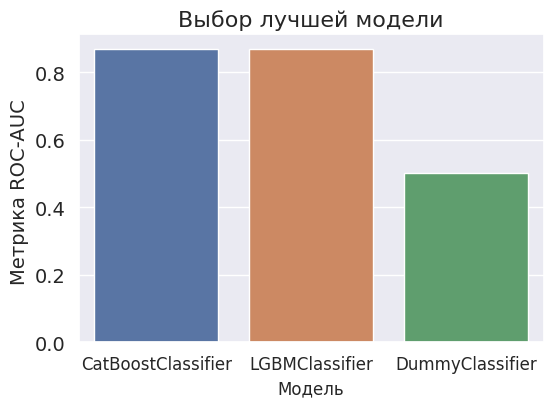

In [ ]:
#define figure size
sns.set(rc={"figure.figsize":(6 , 4 )})
#define seaborn background colors
sns.set (rc={'axes.facecolor':'black', 'figure.facecolor':'white'})
sns.set(rc={'xtick.labelsize':12, 'ytick.labelsize':14})  # размер подписей
sp = sns.barplot(data=df_model, x="Модель", y="best_score_");
sp.axes.set_title("Выбор лучшей модели", fontsize=16)
sp.set_xlabel("Модель", fontsize=12)
sp.set_ylabel("Метрика ROC-AUC ", fontsize=14);    

In [ ]:
best_score = df_model.loc[0, 'best_score_']
best_estimator = df_model.loc[0, 'best_estimator_']
print('Лучшая модель -',  best_estimator[0])
print(f"Метрика ROC-AUC на кросс-валидации = {best_score:.4f}")

Лучшая модель - SelectKBest(k=16, score_func=<function chi2 at 0x7fb6bc066e50>)
Метрика ROC-AUC на кросс-валидации = 0.8699


<div class="alert alert-success">
<h2> Комментарий тимлида<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> хорошо, наглядно

## Тестирование лучшей модели и оценка дополнительных метрик

In [ ]:
# сначала оценим метрику ROC-AUC
probabilities_test = best_estimator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc = roc_auc_score(target_test, best_estimator.predict_proba(features_test)[:, 1])
print(f"Значение метрики ROC-AUC = {roc_auc:.4f}")

Значение метрики ROC-AUC = 0.8819


<div class="alert alert-success">
<h2> Комментарий тимлида<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> отличное качество, порог пройден

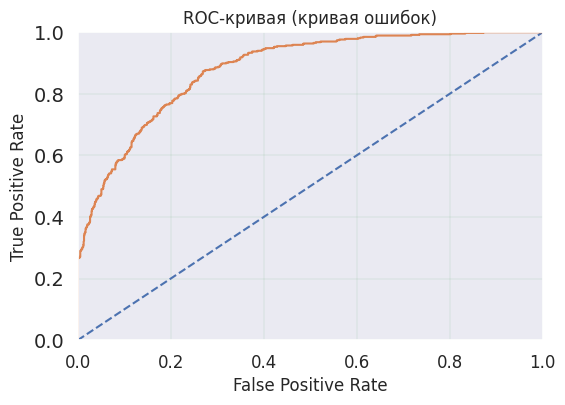

In [ ]:
# вывести ROC-кривую (кривую ошибок)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая (кривая ошибок)')
plt.grid(which='major', axis='both', color='g', linestyle='-', linewidth=0.1)

plt.show() 

In [ ]:
# вывод дополнительных метрик
predicted_test = best_estimator.predict(features_test)
test_f1 = f1_score(target_test, predicted_test)
print(f'Метрика F1_score на тестовой выборке  = {test_f1:.4f}')
accuracy_test = accuracy_score(target_test, predicted_test)
print(f'Метрика Accuracy  на тестовой выборке = {accuracy_test:.4f}')

Метрика F1_score на тестовой выборке  = 0.6296
Метрика Accuracy  на тестовой выборке = 0.8233


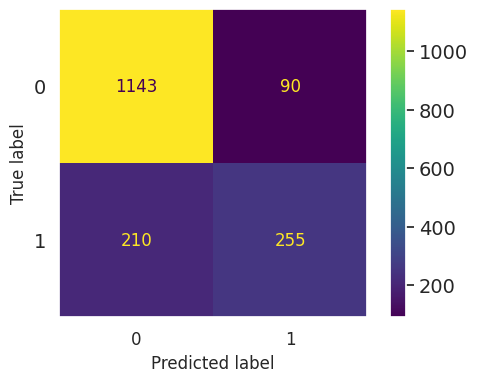

In [ ]:
# Визуализация матрицы ошибок.
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
cm = confusion_matrix(target_test, predicted_test, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator.classes_)
disp.plot()
plt.grid(which='major', axis='both', color='r', linestyle='-', linewidth=0)
plt.show()

In [ ]:
cm

array([[1143,   90],
       [ 210,  255]])

In [ ]:
# текстовый отчет, показывающий основные метрики классификации
# sklearn.metrics.classification_report
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report
print(classification_report(target_test, best_estimator.predict(features_test)))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1233
           1       0.74      0.55      0.63       465

    accuracy                           0.82      1698
   macro avg       0.79      0.74      0.76      1698
weighted avg       0.82      0.82      0.81      1698



<div class="alert alert-success">
<h2> Комментарий тимлида<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> хороший анализ модели

## Анализ важности признаков

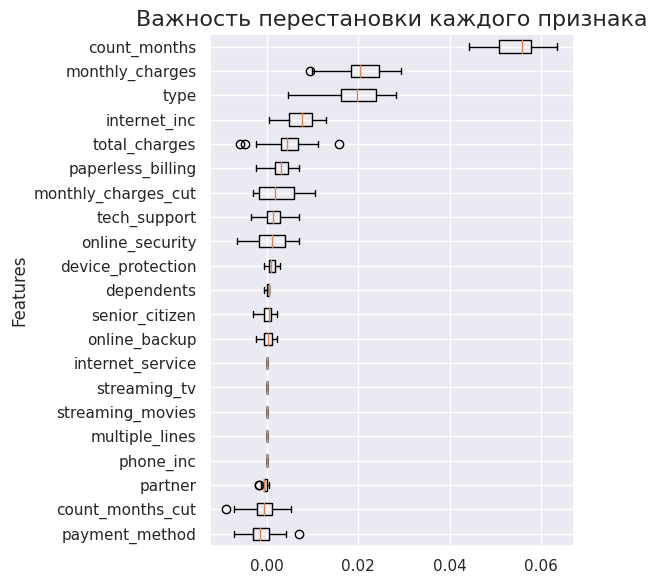

In [ ]:
# Важность перестановки для оценки признаков - графическая форма
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
sns.set(rc={"figure.figsize":( 6 , 6 )})
r = permutation_importance(best_estimator, features_test, target_test, n_repeats=30, random_state=RANDOM_STATE, n_jobs=2)
feature_names = features_test.columns
fig, ax = plt.subplots()
sorted_idx = r.importances_mean.argsort()
ax.boxplot(
    r.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
)
ax.set_title("Важность перестановки каждого признака", fontsize=16)
ax.set_ylabel("Features")
fig.tight_layout()
plt.show()

In [ ]:
# Важность перестановки для оценки признаков - табличная форма
print('Важность перестановки для оценки признаков')
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features_test.columns[i]:<20}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


Важность перестановки для оценки признаков
count_months        0.055 +/- 0.005
monthly_charges     0.021 +/- 0.005
type                0.020 +/- 0.005
internet_inc        0.007 +/- 0.003


<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> плюс за раздел, понятно как модель принимает решение. В будущем можно оставить наиболее значимые признаки и посмотреть на качество модели.

<div style="border:solid Chocolate 2px; padding: 40px">

<h2>✔️ Заключение тимлида: <a class="tocSkip"> </h2> 
    
<b>Александр</b>,  хорошо, по метрике отличный результат, порог пройден, поздравляю! Можно приступать к отчету.



---



---



---

